In [36]:
#Notebook to create results tables, regression of detection factors and subtests

In [1]:
import pandas as pd
import numpy as np
import os
#import meld_classifier.old_hdf5_io as hio
import matplotlib.pyplot as plt
import meld_classifier.paths as paths
from statsmodels.stats.proportion import proportion_confint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
from meld_classifier.meld_cohort import MeldCohort, MeldSubject


Setting MELD_DATA_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
Setting FS_SUBJECTS_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/fs_outputs


In [2]:
demographics_file = '/rds/project/kw350/rds-kw350-meld/meld_data/Data/demographics_qc_allgroups.csv'


In [3]:
folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'
res_file = os.path.join(folder,'test_results.csv')
test_df=pd.read_csv(res_file,index_col=False)
test_df.drop_duplicates(inplace=True,ignore_index=True)
test_df.groupby('group').mean()
fp = test_df['n_clusters']<1
test_df['any']=fp
test_df.border=test_df.border>100
#test_df.detected+=test_df.border
test_df=test_df.dropna()
test_df.detected=test_df.detected.astype(int)

In [4]:
#create results table
def results_row(df):
    # create results table
    #%detected
    #mean = pd.DataFrame(df.groupby('group',as_index=False).mean())
    
    
    detected = np.round(np.mean(df.detected[df.group])*100).astype(int)
    detected_plus = np.round(np.mean(df.detected[df.group]+df.border[df.group])*100).astype(int)
    #np.round(mean['detected'][mean['group']==True].values[0]*100).astype(int)
    
    median = pd.DataFrame(df.groupby('group',as_index=False).median())
    pat_med = median['n_clusters'][median['group']==True].values[0]
    pat_iqr = [np.percentile(df[df['group']==True]['n_clusters'].values,25),
               np.percentile(df[df['group']==True]['n_clusters'].values,75)]
    try:
        cont_med = median['n_clusters'][median['group']==False].values[0]
        cont_iqr = [np.percentile(df[df['group']==False]['n_clusters'].values,25),
               np.percentile(df[df['group']==False]['n_clusters'].values,75)]
        cont_spec = np.round(np.mean(df[df['group']==False]['n_clusters']==0)*100).astype(int)
        row = [ f'{detected_plus}% ({df.detected.sum()+df.border.sum()}/{df.group.sum()})',
           f'{detected}% ({df.detected.sum()}/{df.group.sum()})',
          f'{pat_med} ({pat_iqr[0]}-{pat_iqr[1]})',
          f'{cont_spec}% ({(df[df["group"]==False]["n_clusters"]==0).sum()}/{(df["group"]==0).sum()})',
          f'{cont_med} ({cont_iqr[0]}-{cont_iqr[1]})']
    except IndexError:
        row = [ f'{detected_plus}% ({df.detected.sum()+df.border.sum()}/{df.group.sum()})',
           f'{detected}% ({df.detected.sum()}/{df.group.sum()})',
          f'{pat_med} ({pat_iqr[0]}-{pat_iqr[1]})',
          'NA',
          'NA']
    
    
    
    
    return row

In [5]:
test_row = results_row(test_df)

In [6]:

folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-17/ensemble_21-09-20/fold_all/results'
res_file = os.path.join(folder,'test_results.csv')
n = pd.read_csv(res_file,index_col=False)
n.drop_duplicates(inplace=True,ignore_index=True)
n.dropna(inplace=True)

fp = n['n_clusters']<1
n['any']=fp
n.border=n.border>100
#n.detected+=n.border
n=n.dropna()
test_df=test_df.append(n,ignore_index=True)
test_df['group']=test_df['group'].astype(bool)
full_row = results_row(test_df)


In [7]:
folder  = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/predict_NewSiteH27H28_21-09-20/fold_all/results'
res_file = os.path.join(folder,'test_results.csv')
n = pd.read_csv(res_file,index_col=False)
n.drop_duplicates(inplace=True,ignore_index=True)
n.dropna(inplace=True)


n.border=n.border>100
#n.detected+=n.border
n=n.dropna()
n['group'] = n['group'].astype(bool)
#test_df=test_df.append(n,ignore_index=True)
#test_df['group']=test_df['group'].astype(bool)
site1=np.zeros(len(n),dtype=bool)
for i,s in enumerate(n.ID):
    if 'H27' in s:
        site1[i] = 1
new_sites1 = results_row(n[site1])
new_sites2 = results_row(n[~site1])


In [8]:
data = {'':  ['Sensitivity+ (Percentage of patients detected)',
              'Sensitivity (Percentage of patients detected)',
             'Number of clusters in patients (Median (IQR))',
             'Specificity (Percentage of controls with zero clusters',
             'Number of clusters in controls (Median (IQR))',
             ],
      "Test cohort": test_row,
       "Full cohort":full_row,
       "Independent site 1":new_sites1,
        "Independent site 2":new_sites2,
       }
df = pd.DataFrame(data)
df=df.set_index('')
df.transpose()

,Sensitivity+ (Percentage of patients detected),Sensitivity (Percentage of patients detected),Number of clusters in patients (Median (IQR)),Specificity (Percentage of controls with zero clusters,Number of clusters in controls (Median (IQR))
Test cohort,67% (174/260),59% (154/260),2.0 (1.0-4.0),54% (105/193),0.0 (0.0-1.0)
Full cohort,65% (350/538),58% (314/538),2.0 (1.0-4.0),52% (194/373),0.0 (0.0-2.0)
Independent site 1,94% (16/17),88% (15/17),3.0 (2.0-4.0),17% (3/18),1.0 (1.0-2.75)
Independent site 2,62% (10/16),56% (9/16),3.0 (2.0-4.25),NA,NA


In [9]:
test_df.detected+=test_df.border
test_df.detected=test_df.detected.astype(int)


In [10]:
len(np.unique(n.ID)),len(n)
len(np.unique(test_df.ID)),len(test_df)


(911, 911)

In [11]:
#df = pd.read_csv(res_file,index_col=False)
test_df.groupby('group').mean()
fp = test_df['n_clusters']==1
test_df['any']=fp
test_df.groupby('group').mean()

,detected,n_clusters,border,any
group,,,,
False,0.000000,1.080429,0.000000,0.227882
True,0.650558,2.691450,0.066914,0.267658


In [12]:
# df = test_df.append(train_df)
# df=df.reset_index()
df = test_df
#df.border = df.borded
df['detected'] = df['detected'].astype(float)
df[np.isnan(df['detected'])]

,ID,group,detected,n_clusters,border,any


In [13]:
demographics = pd.read_csv(demographics_file,index_col=False)

In [14]:
qc_scores = pd.read_csv(os.path.join(paths.BASE_PATH,'OLD','analysis_outliers_qc_v3.csv'))

In [15]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset=None)

In [22]:
empty=[]
site=[]
scanner=[]
flair=[]
qc_score = []
for c in demographics.columns[1:]:
    df[c]=0
df['qc_score'] = 0
for sub in df['ID']:
    for c in demographics.columns[1:]:
        df[c][df.ID==sub] = demographics[c][demographics.ID==sub].values[0]
#     empty.append(demographics[demographics.columns[1:]][demographics.ID==sub].values)
#     site.append(sub.split('_')[1])
#     scanner.append(sub.split('_')[2])
    
#     subj = MeldSubject(sub, cohort=cohort)
#     flair.append('FLAIR' in subj.get_feature_list()[-1])
    df['qc_score'][df.ID==sub] = qc_scores['perc_outliers_rois'][qc_scores.ID==sub].values[0]
    #qc_score.append(qc_scores['perc_outliers_rois'][qc_scores.ID==sub].values[0])
    
# empty=np.ndarray.squeeze(np.array(empty))

/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [23]:
n_site={}
for site in np.unique(df.Site):
    n_site[site]={}
    site_grouped=pd.DataFrame(df.groupby(['Site','Scanner']).count().ID[site].reset_index(name = "Group_Count"))
    for scanner in site_grouped.Scanner:
        n_site[site][scanner]=site_grouped.Group_Count[site_grouped.Scanner==scanner].values[0]
site_size = []
for sub in df['ID']:
    site_size.append(n_site[df.Site[df.ID==sub].values[0]][df.Scanner[df.ID==sub].values[0]])
df['Site_scanner_size']=site_size


In [24]:
histo ='FCD IIIB'

list_fcd=['FCD3', 'FCD 3', 'FCDIII', 'FCD III']

if any(key in histo for key in list_fcd):
    print(histo)

FCD IIIB


In [25]:
#df.border=df.border>100
#df.detected+=df.border
pat=df[df['group']=='patient'].copy()
#df = df[df['site']!='H7']

In [36]:
np.median(df[df.Site=='H4']['n_clusters'])

3.0

In [40]:
site_r=pat.groupby(['Site',]).mean()
site_r

,detected,n_clusters,border,any,Age of onset,Duration,Age at preoperative,Sex,Ever reported MRI negative,Engel Outcome,Surgery,f/u,FreeSurfer,Seizure free,qc_score,Site_scanner_size
Site,,,,,,,,,,,,,,,,
H10,0.428571,2.214286,0.000000,0.357143,10.928571,17.142857,28.071429,0.285714,0.642857,2.071429,1.000000,2.150000,5.3,0.428571,2.130326,45.000000
H11,0.794872,2.974359,0.076923,0.230769,7.338974,9.700769,17.039744,0.589744,0.512821,1.025641,1.000000,1.510000,5.3,0.974359,1.904333,39.000000
H12,0.588235,1.470588,0.058824,0.470588,12.291667,21.541667,35.142857,0.117647,0.411765,1.583333,0.764706,6.008333,5.3,0.750000,2.579979,62.000000
H14,0.833333,2.357143,0.023810,0.238095,5.589286,5.601190,11.190476,0.571429,0.452381,1.793103,0.761905,0.896552,5.3,0.689655,2.887682,67.000000
H15,0.727273,3.545455,0.000000,0.272727,12.727273,20.272727,33.000000,0.363636,0.363636,1.500000,0.363636,3.500000,NaN,0.500000,4.412324,48.000000
H16,0.666667,1.833333,0.033333,0.333333,7.922000,17.944667,25.866667,0.500000,0.500000,1.482759,1.000000,NaN,5.3,0.655172,1.988304,30.000000
H17,0.611765,2.023529,0.035294,0.364706,14.086706,18.550941,32.637647,0.388235,0.176471,1.619048,0.494118,3.021429,5.3,0.642857,2.742363,65.847059
H18,0.733333,4.000000,0.133333,0.466667,3.746667,6.547333,10.294000,0.333333,0.133333,NaN,0.800000,NaN,6.0,NaN,1.656186,15.000000
H19,1.000000,1.500000,0.000000,0.500000,6.125000,35.875000,42.000000,0.000000,0.000000,NaN,0.000000,NaN,5.3,NaN,5.847953,29.000000


In [21]:
# fig,axes=plt.subplots(2,2)
# axes[0,0].hist(site_r.detected)
# axes[0,0].set_xlim([0,1])
# axes[0,0].set_title('Baseline detected')
# axes[0,1].hist(site_r.border)
# axes[0,1].set_xlim([0,1])
# axes[0,1].set_title('Baseline borderzone')

# axes[1,0].scatter(site_r.border,site_r.detected,
#                   c=np.array(site_r.index=='H24').astype(int))
# axes[1,0].set_title(f'Detected vs borderzone,\nR = {np.round(np.corrcoef(site_r.border,site_r.detected)[0,1],2)}')
# axes[1,0].set_ylabel('Detected (sensitivity)')
# axes[1,0].set_xlabel('Borderzone')

# axes[1,1].hist(site_r.detected+site_r.border)
# axes[1,1].set_xlim([0,1])
# axes[1,1].set_title('Detected + border')
# plt.tight_layout()

In [22]:
#filter to see what the issue with FLAIR & 3T was
# # df = df[df['flair']]
# # df=df[df['group']]
# # df=df[df['scanner']=='3T']
# # tmp=pd.DataFrame(df.groupby('site').mean()['detected'])
# # tmp['counts'] = df.groupby('site').count()['detected']
# print(np.mean(df['detected'][df['site']!='H24']),np.mean(df['detected']))


In [23]:
y = df['detected'][df['group']]


In [24]:
#site size
df

,ID,group,detected,n_clusters,border,any,Site,Age of onset,Duration,Age at preoperative,...,f/u,FreeSurfer,Scanner,lesion,Hemisphere,Lobe,FLAIR,Seizure free,qc_score,Site_scanner_size
0,MELD_H2_15T_FCD_0001,patient,0.0,0,False,False,H2,15.0,5.0,20.0,...,5.0,5.3,15T,True,lh,temporal,False,1.0,0.584795,31
1,MELD_H2_15T_FCD_0003,patient,0.0,0,False,False,H2,0.9,9.1,10.0,...,NaN,5.3,15T,True,rh,temporal,False,NaN,2.923977,31
2,MELD_H2_15T_FCD_0005,patient,0.0,0,False,False,H2,7.0,13.0,20.0,...,NaN,5.3,15T,True,lh,temporal,False,NaN,0.000000,31
3,MELD_H2_15T_FCD_0007,patient,1.0,1,False,True,H2,0.1,3.9,4.0,...,2.0,5.3,15T,True,rh,frontal,False,1.0,2.339181,31
4,MELD_H2_15T_FCD_0008,patient,0.0,1,False,True,H2,7.0,3.0,10.0,...,NaN,5.3,15T,True,rh,frontal,False,NaN,4.678363,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,MELD_H24_3T_FCD_0035,patient,0.0,0,False,False,H24,15.0,28.0,43.0,...,1.0,6.0,3T,True,lh,frontal,True,0.0,2.092050,38
907,MELD_H24_3T_FCD_0039,patient,1.0,3,False,False,H24,8.0,37.0,45.0,...,1.0,6.0,3T,True,rh,temporal,False,0.0,0.584795,38
908,MELD_H26_15T_FCD_0006,patient,1.0,2,False,False,H26,5.0,3.0,8.0,...,1.0,5.3,15T,True,lh,temporal,False,1.0,4.093567,5
909,MELD_H26_3T_FCD_0003,patient,1.0,1,False,True,H26,6.0,1.0,7.0,...,2.0,5.3,3T,True,lh,frontal,False,1.0,0.000000,5


In [25]:

feature_sets = [[
    'Age at preoperative', 
                      'Sex', 'Ever reported MRI negative',
        'Hemisphere',#'Lobe', 
    'Scanner','FLAIR','Surgery',
'detected','FreeSurfer'],
    [
        'Histology','Seizure free','detected'
        ],
    
]
features_of_interest = feature_sets[0]

In [26]:
#.columns


/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


KeyboardInterrupt: 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


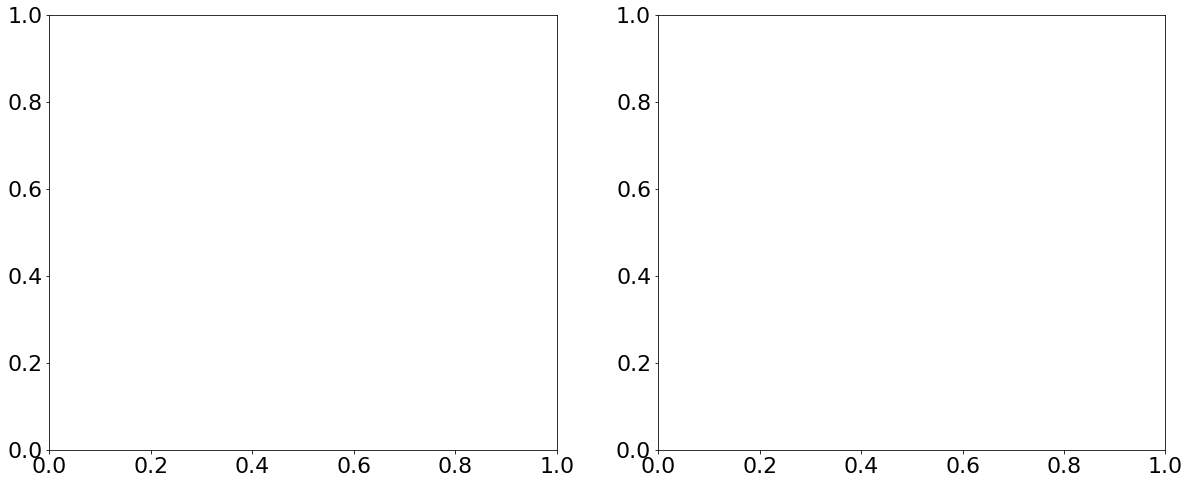

In [27]:
n_perm=10000
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
np.random.seed(42)
fig, ax = plt.subplots(1,2,figsize=(20,8))
for f, features_of_interest in enumerate(feature_sets):
    x=df[features_of_interest][df['group']=='patient']
    if f==0:
        x=x.fillna(0)
        x['Age at preoperative'] = (x['Age at preoperative']).astype(float)
        x['Hemisphere']=x['Hemisphere']=='lh'
        x['Scanner']=x['Scanner']=='15T'
        x['FreeSurfer']=x['FreeSurfer']==6.
        x=x.rename(columns={'Age at preoperative':'Age at scan',"Scanner":"MRI:1.5T",
                           "Sex":"Sex:Male","Hemisphere":"Hemisphere:left",
                           "FreeSurfer":"FreeSurfer:v6"})
        x['1.5T*FLAIR'] = x['MRI:1.5T']*x['FLAIR']
        x=x[['Age at scan', 'Sex:Male', 'Ever reported MRI negative',
       'Hemisphere:left', 'MRI:1.5T', 'FLAIR','1.5T*FLAIR', 'Surgery', 'FreeSurfer:v6',
       'detected']]
        
    else:
        x=x.dropna()
        x['Seizure free'] = x['Seizure free'].astype(int)
    y = x['detected'].astype(int)
    x=x.drop(columns=['detected'])
    
    X=pd.get_dummies(x)
    if f==1:
        for c in X.columns:
            if 'Histology' in c:
                new_c = ' '.join(c.split('_')[1:])
                X=X.rename(columns={c:new_c})
    clf = LogisticRegression(solver='liblinear')

    clf.fit(X,y)
    coefs = clf.coef_.ravel()
    #permutation-based statistics
    perm_coefs = np.zeros((n_perm,clf.coef_.shape[1]))
    y_perm=np.array(y).copy()
    for perm in np.arange(n_perm):
        np.random.shuffle(y_perm)
        clf.fit(X,y_perm)
        perm_coefs[perm]=clf.coef_
    pvals=(0.5-np.abs(0.5-np.mean(coefs>perm_coefs ,axis=0)))*2
    pd.DataFrame([coefs,pvals], columns=X.columns)
    sig,pcorr,_,_=multipletests(pvals,0.05,method='fdr_bh')
    y_pos = np.arange(len(coefs))
    #set colours
    colors=[]
    for i in y_pos:
        if coefs[i]>0:
            colors.append([1,0,0,0.4+0.6*sig[i]])
        else:
            colors.append([0,0,1,0.4+0.6*sig[i]])

    
    ax[f].barh(y_pos, coefs,color=colors , align='center')
    ax[f].set_yticks(y_pos)
    ax[f].set_yticklabels(X.columns);
    ax[f].invert_yaxis()  # labels read top-to-bottom
    ax[f].set_xlabel('Logistic coefficient\nLess likely detected -> more likely detected')
    ax[f].set_title('');
    ax[f].text(-0.1,1,['A','B'][f],transform = ax[f].transAxes,fontsize=30)
ax[f].set_yticklabels(['Seizure free', 'FCD I', 'FCD IIA', 'FCD IIB', 'FCD III']);
plt.tight_layout()
fig.savefig('logistic_regression.pdf')

In [ ]:
fig.savefig('Figure_logistic_regression.png')

In [ ]:
# import ptitprince as pt
# pat['log_a'] = np.log(pat['Lesion area'])
# plt.figure(figsize=(8,8))
# pt.RainCloud(y='log_a',x='Site',data=pat)
# #pat.groupby('Site').median()

In [28]:
pat = df[df['group']=='patient']


In [29]:
disp_df=pd.DataFrame(100*pat.groupby('Scanner').mean()['detected']).round(1)
disp_df['count'] = pat.groupby('Scanner').count()['detected']
disp_df

,detected,count
Scanner,,
15T,58.8,97
3T,66.4,441


In [30]:
    
disp_df=pd.DataFrame(100*pat.groupby(['Scanner','FLAIR']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Scanner','FLAIR']).count()['detected']
disp_df


detected  count
Scanner FLAIR                 
15T     False      46.0     63
        True       82.4     34
3T      False      63.9    233
        True       69.2    208

In [31]:
disp_df=pd.DataFrame(100*pat.groupby(['Seizure free']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Seizure free']).count()['detected']
disp_df


,detected,count
Seizure free,,
0.0,58.6,111
1.0,69.9,229


In [57]:
det=pat[np.logical_and(pat['FLAIR'],np.logical_and(pat['Scanner']=='3T',np.logical_and(pat['Seizure free']==1,
                                          np.logical_or(pat['Histology']=='FCD_2B',
                                                       pat['Histology']=='FCD_2A'))))]
det=pat[np.logical_and(pat['FLAIR'],np.logical_and(pat['Scanner']=='3T',np.logical_and(pat['Seizure free']==1,
                                          pat['Histology']=='FCD_2B')))]
det=pat[np.logical_and(pat['Seizure free']==1,np.logical_and(pat['FLAIR'],
                                          pat['Histology']=='FCD_2B'))]
np.mean(det.detected)

0.85

In [34]:
pat['fcd_2_seizure_free'] = np.logical_and(pat['Seizure free']==1,
                                          np.logical_or(pat['Histology']=='FCD_2B',
                                                       pat['Histology']=='FCD_2A'))
pat['fcd_2'] =     np.logical_or(pat['Histology']=='FCD_2B',
                                                       pat['Histology']=='FCD_2A')

disp_df=pd.DataFrame(100*pat.groupby(['fcd_2_seizure_free']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['fcd_2_seizure_free']).count()['detected']
disp_df

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,detected,count
fcd_2_seizure_free,,
False,59.8,361
True,75.7,177


In [54]:
pat.Histology[pat.Histology.isna()]='None'

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [55]:

disp_df=pd.DataFrame(100*pat.groupby(['Histology']).mean()['detected']).round(1)
disp_df['n patients'] = pat.groupby(['Histology']).count()['detected']
disp_df.rename(columns={'detected':'% Detected'})


,% Detected,n patients
Histology,,
FCD_1,50.0,44
FCD_2A,64.6,113
FCD_2B,76.8,185
FCD_3,72.7,22
None,55.7,174


In [56]:
disp_df=pd.DataFrame(100*pat.groupby(['Ever reported MRI negative']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['Ever reported MRI negative']).count()['detected']
disp_df

,detected,count
Ever reported MRI negative,,
0.0,66.1,360
1.0,62.9,178


In [57]:
pat['paediatric'] = pat['Age at preoperative']<18
disp_df=pd.DataFrame(100*pat.groupby(['paediatric']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['paediatric']).count()['detected']
disp_df

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,detected,count
paediatric,,
False,62.4,282
True,68.0,256


In [ ]:
disp_df=pd.DataFrame(100*pat.groupby(['flair','scanner','Histology']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['flair','scanner','Histology']).count()['detected']
disp_df

In [112]:
sf_df = pat[~pat['Seizure free'].isna()]
sf_df['Seizure free']=sf_df['Seizure free'].astype(int)
sf_df['n_clusters']=np.clip(sf_df['n_clusters'],0,4)
sf_df['t_ext'] = sf_df['Lobe']=='temporal'
#sf_df = sf_df[['detected','Seizure free','n_clusters']]

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [ ]:
disp_df=pd.DataFrame(sf_df.groupby(['t_ext']).mean()['Seizure free'])
disp_df['count'] = sf_df.groupby(['t_ext']).count()['Seizure free']
st.fisher_exact(np.array([disp_df['Seizure free'],disp_df['count']-disp_df['Seizure free']]))

In [ ]:
disp_df=pd.DataFrame(sf_df.groupby(['t_ext']).mean()['Seizure free'])
disp_df

In [ ]:
plt.hist(pat.n_clusters,15)
plt.xlabel('n clusters')
plt.ylabel('count')

In [ ]:
#sf_df['n_clusters'] = sf_df['n_clusters']+sf_df['detected']
disp_df=pd.DataFrame(sf_df.groupby(['n_clusters']).mean()['Seizure free'])
disp_df['count'] = sf_df.groupby(['n_clusters']).count()['Seizure free']
disp_df['std']=sf_df.groupby(['n_clusters']).std()['Seizure free']
disp_df

In [ ]:
import scipy.stats as st
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

contingency_table = np.array([disp_df['Seizure free']*disp_df['count'],disp_df['count']-disp_df['Seizure free']*disp_df['count']])
#print(st.chisquare(contingency_table.T))
mc=MultiComparison(sf_df['Seizure free'],sf_df['n_clusters'])
result=mc.tukeyhsd()
print(result)

In [ ]:
e=[]
for k in np.arange(len(disp_df)):
    l,u=proportion_confint(disp_df['Seizure free'][k]*disp_df['count'][k],disp_df['count'][k])
    e.append((u-l)/2)
plt.errorbar(disp_df.index,disp_df['Seizure free'],yerr=e,fmt='o')
    
plt.xticks(np.arange(5));

In [ ]:
disp_df['Seizure free'][k]*disp_df['count'][k]

In [ ]:
disp_df=pd.DataFrame(100*pat.groupby(['site']).mean()['detected']).round(1)
disp_df['count'] = pat.groupby(['site']).count()['detected']
site=[]
for sub in train_df['ID']:
    site.append(sub.split('_')[1])
train_df['site']=site
train_pat = train_df[train_df['group']==1]

trdisp_df=pd.DataFrame(100*train_pat.groupby(['site']).mean()['detected']).round(1)
trdisp_df['count'] = train_pat.groupby(['site']).count()['detected']
disp_df['detected_train']=trdisp_df['detected']
disp_df['count_train']=trdisp_df['count']
disp_df.sort_values('detected')
#plt.scatter(disp_df['detected'],disp_df['count'])
disp_df.sort_values('detected')


In [32]:
test_df = pd.read_csv(os.path.join(folder,'test_results.csv'))
train_df = pd.read_csv(os.path.join(folder,'train_results.csv'))
combi = test_df.append(train_df)
combi_pat = combi[combi.group]

In [6]:

cohort_sizes=[20,40,60,100,150,200,400]
res = np.zeros((len(cohort_sizes),1000))
n_subs= np.zeros((len(cohort_sizes),1000))
for k,n in enumerate(cohort_sizes):
    for p in np.arange(1000):
        subs=np.sort(np.random.choice(np.arange(len(combi_pat)),n))
        bool_ = np.zeros(len(combi_pat)).astype(bool)
        bool_[subs]=1
        correct=np.random.random(n)<0.6
        res[k,p] = np.mean(correct)
        n_subs[k,p] = n

In [7]:
# res=np.zeros(100000)
# n_subs=np.zeros(100000).astype(int)
# for k in np.arange(100000):
#     n_subs[k] =  np.random.choice(np.arange(390)+11)
#     res[k] = np.mean(np.random.random(n_subs[k])<0.6)
# from pygam import LinearGAM
# gam = LinearGAM()
# gam = LinearGAM().fit(n_subs, res)
# plt.scatter(n_subs,res,alpha=0.01)
# xx = np.arange(400)+1
# plt.plot(xx,gam.confidence_intervals( X=xx, width=.95), c='r', ls='--')
# plt.ylim([0.4,0.8])

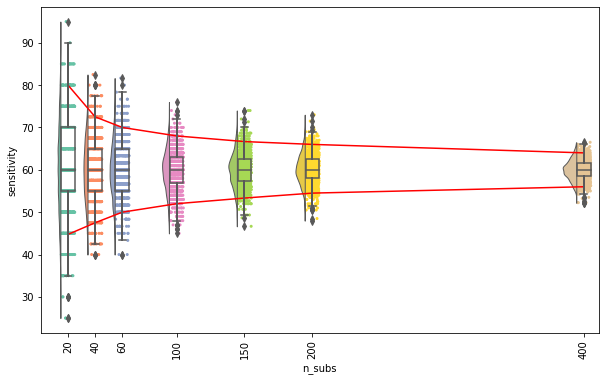

In [10]:
import ptitprince as pt
import matplotlib.cm as cm
colors=cm.Set2(np.arange(len(cohort_sizes)))
my_pal={}
k=-1
for c in np.arange(401):
    if c in cohort_sizes:
        k+=1
        my_pal[c]=colors[k]
    else:
        my_pal[c]=colors[k]
#matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cohort_sizes,100*np.percentile(res,5,axis=1),'r')
ax.plot(cohort_sizes,100*np.percentile(res,95,axis=1),'r')
df_sense=pd.DataFrame(np.array([100*res.ravel(),n_subs.ravel()]).T,
                      columns=['sensitivity','n_subs'])
pt.RainCloud(y='sensitivity',x='n_subs',data=df_sense,
             ax=ax,order=np.arange(401),width_viol = 20, width_box = 10,
            jitter=5,palette=my_pal)
ax.set_xlim([0,411])
ax.set_xticks(cohort_sizes);
ax.set_xticklabels(cohort_sizes,rotation=90,ha='center');


In [220]:
confidence_intervals=np.zeros((200,2))
confidence_intervals_90=np.zeros((200,2))
for n in np.arange(200):
    confidence_intervals[n]=proportion_confint(0.6*(n+1),n+1)
    confidence_intervals_90[n]=proportion_confint(0.6*(n+1),n+1,alpha=0.1)

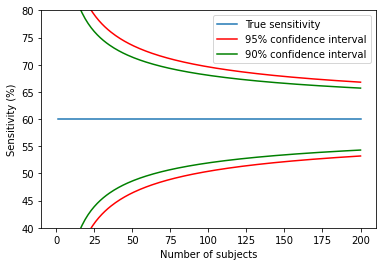

In [229]:
plt.plot(np.arange(200)+1,100*np.ones(200)*0.6,label='True sensitivity')
plt.plot(np.arange(200)+1,100*confidence_intervals,'r')
plt.plot(np.arange(200)+1,100*confidence_intervals_90,'g')

plt.plot([0],[0],'r',label='95% confidence interval')
plt.plot([0],[0],'g',label='90% confidence interval')


plt.xlabel('Number of subjects')
plt.ylabel('Sensitivity (%)')
plt.ylim([40,80])
plt.legend()